# Validation of ESG module

In [32]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from project.source.noise import NoiseGenerator
from project.source.esg import EconomicScenarioGenerator

In [33]:
N = 100000
interval = 12
T = 5
steps = interval * T

### Simulation parameters

In [34]:
with open('../data/params.pkl', 'rb') as f:
     s0, Corr, variance, mean, ar = pickle.load(f)

In [35]:
s0

EQ_SWE          224.480000
EQ_WORLD       4041.233665
ALTERNATIVE     100.000000
CPI             278.000000
PROPERTY        100.400000
IR_1              0.029400
IR_5              0.039880
IR_15             0.048920
SPREAD            0.003790
Name: 2003-12-31, dtype: float64

### Pick index of a stock and a rate

In [36]:
Si = np.where(s0.index == 'EQ_SWE')[0][0]
ri = np.where(s0.index == 'IR_1')[0][0]

In [37]:
S0 = s0.to_numpy()[[Si, ri]]
a = ar.to_numpy()[[Si, ri]]
mu = mean.to_numpy()[[Si, ri]]
sigma = np.sqrt(variance.to_numpy()[[Si, ri]])
corrmatrix = Corr.to_numpy()[np.ix_([Si,ri],[Si,ri])]

## Simulate

In [38]:
NG = NoiseGenerator()
dB = NG.normal_steps(corrmatrix, N * steps)

In [8]:
dB.shape

(2, 6000000)

In [39]:
ESG = EconomicScenarioGenerator(S0, a, mu, sigma, dB)
EQ, IR = ESG.get_scenarios(N, steps, interval)

### Stocks

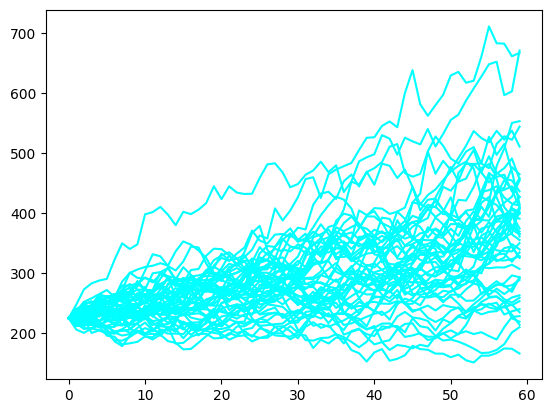

In [40]:
for s in EQ[:50]:
    plt.plot(s.T, color='cyan')

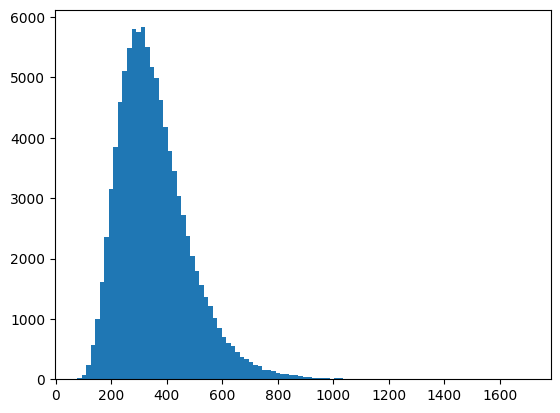

In [41]:
counts, bins = np.histogram(EQ[:,:,-1], bins=100)
plt.hist(bins[:-1], bins, weights=counts);

Log-normal

### Values in 1% quantiles

In [42]:
[bins[1],bins[99]]

[94.98507150798778, 1685.5314204635727]

### Rates

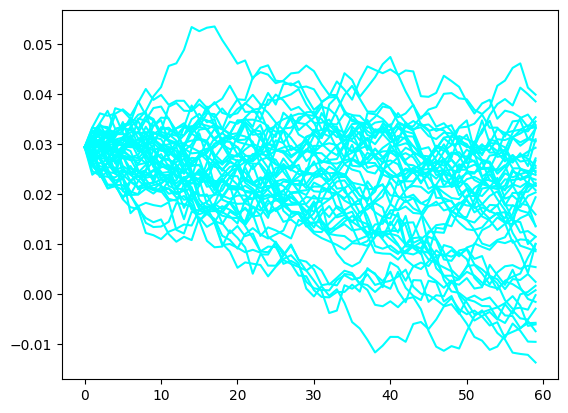

In [43]:
for r in IR[:50]:
    plt.plot(r.T, color='cyan')

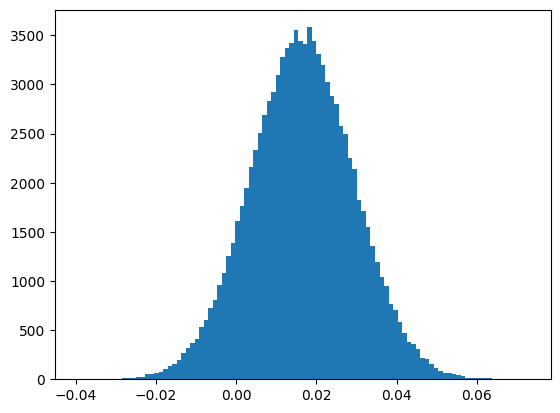

In [44]:
counts, bins = np.histogram(IR[:,:,-1], bins=100)
plt.hist(bins[:-1], bins, weights=counts);

Normal

## Validate

In [45]:
sim_stock_returns = np.diff(np.log(np.squeeze(EQ)))
#sim_stock_returns = np.diff(np.squeeze(AK))
sim_rate_returns = np.diff(np.squeeze(IR))

### Correlation

In [46]:
np.corrcoef(sim_stock_returns.flatten(), sim_rate_returns.flatten())[0, 1]

0.20242559468213925

In [47]:
corrmatrix[0, 1]

0.2028056013640747

### Variance

In [48]:
np.diag(np.cov(sim_stock_returns.flatten(), sim_rate_returns.flatten())) * interval

array([2.55217605e-02, 5.08789898e-05])

In [49]:
sigma**2

array([2.57727660e-02, 5.07720393e-05])

### Mean

$E[S_T] = S_0 e^{\mu T}$

In [50]:
np.mean(EQ[:,0,-1])

356.7871181026259

In [51]:
S0[0] * np.exp(mu[0] * T)

359.68157778016155

 $E[r_T] = r_0 e^{-aT} + \mu (1 - e^{-aT})$

In [52]:
np.mean(IR[:,0,-1])

0.016437574648656098

In [53]:
S0[1] * np.exp(-a[1] * T) + mu[1] * (1 - np.exp(-a[1] * T))

0.016251581081708114

### Correlation matrix estimate

In [68]:
N = 10000 # simulations
interval = 12 # monthly
T = 5 # years
steps = interval * T

In [69]:
s0 = np.array([224.0, 234.0, 0.03]) # initial value
a = np.array([0.0, 0.0, 0.09]) # speed of reversion (rates)
mu = np.array([0.094, 0.094, -0.007]) # drift (stocks), long term mean level (rates)
sigma = np.array([0.16, 0.16, 0.007]) # volatility
corrmatrix = np.array([[1.0, 1.0, 0.2], [1.0, 1.0, 0.2], [0.2, 0.2, 1.0]])

In [70]:
NG = NoiseGenerator()
dB = NG.normal_steps(corrmatrix, N * steps)
ESG = EconomicScenarioGenerator(s0, a, mu, sigma, dB)

In [71]:
EQ, IR = ESG.get_scenarios(N, steps, interval)

In [72]:
scenarios = np.concatenate((EQ, IR), axis=1)
scenarios.shape

(10000, 3, 60)

In [73]:
diff = np.diff(scenarios, axis=2)
mean_corr_matrix = np.sum([np.corrcoef(d) for d in diff], axis=0) / diff.shape[0]
mean_corr_matrix

array([[1.        , 1.        , 0.19467642],
       [1.        , 1.        , 0.19467642],
       [0.19467642, 0.19467642, 1.        ]])